ResNet Training (CIFAR - 10)
1. Import Library & Define Resnet model

In [1]:
import torch
import torch.nn as nn

from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import torchvision
import torchvision.transforms as transforms


class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        

conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels
    


class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
        
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )
        
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x
    
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x
    

class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x
    
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

2. Download CIFAR-10

In [2]:
#Download CIFAR10 DATASET

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), 

    transforms.ToTensor(), normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(), normalize
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


3. CUDA setting & Define Train,Test function

In [3]:
#gpu setting & define Training function

device = 'cuda'

net = resnet101(3,10)           #resnet101 선언
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.1
file_name = 'resnet101_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())

    print('\nTotal benign train accuarcy:', 100. * correct / total)
    print('Total benign train loss:', train_loss)
    total_accuracy = 100. * correct / total;

    return total_accuracy , train_loss


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)
    total_accuracy = 100. * correct / total;
    test_loss = loss / total

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    return total_accuracy , test_loss

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

4. Run Training & Save log

In [4]:
# for epoch in range(0, 60):
log_train_total_accuracy =[]
log_train_total_loss = []
log_test_total_accuracy =[]
log_test_total_loss =[]


for epoch in range(0, 100):
    adjust_learning_rate(optimizer, epoch)
    train_total_accuracy, train_total_loss = train(epoch)
    test_total_accuracy, test_total_loss = test(epoch)
    log_train_total_accuracy.append(train_total_accuracy)
    log_train_total_loss.append(train_total_loss)
    log_test_total_accuracy.append(test_total_accuracy)
    log_test_total_loss.append(test_total_loss)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Current benign train loss: 1.1637345552444458

Current batch: 600
Current benign train accuracy: 0.65625
Current benign train loss: 0.9354060292243958

Current batch: 700
Current benign train accuracy: 0.6875
Current benign train loss: 0.6835941076278687

Current batch: 800
Current benign train accuracy: 0.5625
Current benign train loss: 1.1555253267288208

Current batch: 900
Current benign train accuracy: 0.6875
Current benign train loss: 0.8008561730384827

Current batch: 1000
Current benign train accuracy: 0.53125
Current benign train loss: 1.3622184991836548

Current batch: 1100
Current benign train accuracy: 0.46875
Current benign train loss: 1.1826459169387817

Current batch: 1200
Current benign train accuracy: 0.6875
Current benign train loss: 0.9004433751106262

Current batch: 1300
Current benign train accuracy: 0.8125
Current benign train loss: 0.5116458535194397

Current batch: 1400
Current benign train accuracy: 0.46875
Current benign trai

5. Plotting Train Accuracy & Loss

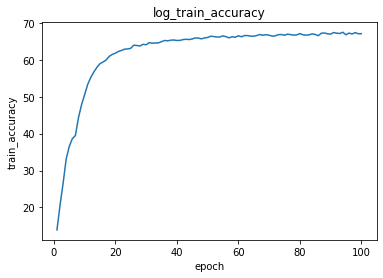

In [5]:
epoch =[]

for i , loss in enumerate(log_test_total_loss):
  epoch.append(i+1)

import matplotlib.pyplot as plt

plt.title('log_train_accuracy')
plt.plot(epoch , log_train_total_accuracy)
plt.xlabel('epoch')
plt.ylabel('train_accuracy')
plt.show()

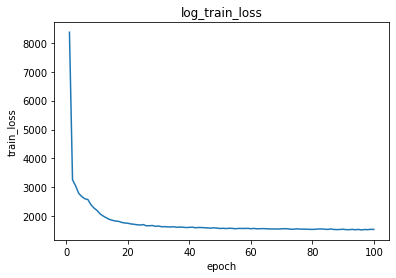

In [6]:
import matplotlib.pyplot as plt

plt.title('log_train_loss')
plt.plot(epoch , log_train_total_loss)
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.show()

6. Plotting Test Accuracy & Loss

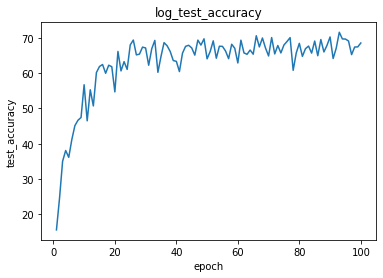

In [7]:
import matplotlib.pyplot as plt

plt.title('log_test_accuracy')
plt.plot(epoch , log_test_total_accuracy)
plt.xlabel('epoch')
plt.ylabel('test_accuracy')
plt.show()

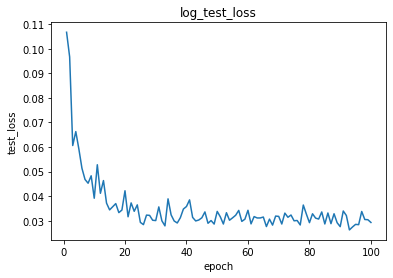

In [8]:
import matplotlib.pyplot as plt

plt.title('log_test_loss')
plt.plot(epoch , log_test_total_loss)
plt.xlabel('epoch')
plt.ylabel('test_loss')
plt.show()

7. Print Result

In [9]:
print(log_train_total_accuracy)
print(log_train_total_loss) 
print(log_test_total_accuracy)
print(log_test_total_loss)

[13.874, 20.562, 26.506, 33.11, 36.516, 38.63, 39.486, 44.332, 47.838, 50.578, 53.356, 55.25, 56.742, 57.992, 58.988, 59.448, 59.988, 60.98, 61.498, 61.848, 62.318, 62.582, 62.926, 62.988, 63.166, 64.012, 63.922, 63.79, 64.248, 64.122, 64.696, 64.558, 64.598, 64.63, 64.954, 65.29, 65.198, 65.366, 65.418, 65.296, 65.306, 65.532, 65.616, 65.54, 65.698, 65.982, 65.938, 65.73, 65.99, 66.1, 66.436, 66.364, 66.22, 66.242, 66.55, 66.3, 66.01, 66.312, 66.158, 66.568, 66.286, 66.63, 66.612, 66.472, 66.446, 66.636, 66.91, 66.71, 66.87, 66.72, 66.474, 66.546, 66.87, 66.902, 66.704, 67.008, 66.872, 66.734, 66.808, 67.154, 66.832, 66.722, 66.826, 67.064, 66.932, 66.584, 67.266, 67.324, 67.112, 67.01, 67.444, 67.268, 67.18, 67.524, 66.832, 67.302, 67.042, 67.438, 67.122, 67.136]
[8365.783673763275, 3259.3487960100174, 3050.54653775692, 2792.7285112142563, 2677.903884410858, 2604.095287799835, 2575.5311648845673, 2396.0522525906563, 2281.445233464241, 2195.3171661496162, 2077.8700806498528, 2004.0515

8. Model Summary

In [10]:
from torchsummary import summary

model = resnet101(3, 10)
summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 256, 8, 8]          16,384
       BatchNorm2d-6            [-1, 256, 8, 8]             512
        Conv2dAuto-7             [-1, 64, 8, 8]           4,096
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
       Conv2dAuto-10             [-1, 64, 8, 8]          36,864
      BatchNorm2d-11             [-1, 64, 8, 8]             128
             ReLU-12             [-1, 64, 8, 8]               0
       Conv2dAuto-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25